# <a id="top_section"></a>

<div align='center'><font size="6" color="#000000"><b>NLP with disaster tweets!(BERT explained) <br>(~84.5% Accuracy)</b></font></div>
<hr>
<div align='center'><font size="5" color="#000000">About the problem</font></div>
<hr>

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.<br>
I have two notebooks on this competition , the first one is using basic naive-base model whereas this one is by using BERT pre-trained model. If you're a beginner I highly recommend you to check out the basic model notebook first ! Here is the link <br>
#### [NLP w/ Disaster tweets!(Explained)](https://www.kaggle.com/friskycodeur/nlp-w-disaster-tweets-explained)
<br>
<img src='https://c7.uihere.com/files/932/486/348/tweet-bird-logotwitter-icon-buttonflat-social-vector.jpg' height=500 width=500>

### Here are the things I will try to cover in this Notebook:

- Defining helper functions
- Data cleaning (basic and advanced both)
- Using BERT model to get higher accuracy
- Is it posible to get 100% accuracy and if yes then how can you get that !

### If you liked this kernel feel free to upvote and leave feedback, thanks!

First , let us start with some basic understandings.

<h1 align='center'> BERT </h1>

BERT stands for Bidirectional Encoder Representation from Transformers. In a transformer flow if we stack a number of encoders then we get a BERT. It is easier to make BERT understand a language. BERT also has a variety of problems such as Question-Answering , Sentiment Analysis , Text sumamrzation ,etc. <br>
Steps to use a BERT model : <br>
- Pretraining BERT : To understand language
- Fine tune BERT : To help us in our specific task

#### Pretraining BERT 
- To make BERT learn what is language.
- It has two part Masked Langauge Modelling(MLM) and Next Sentence Prediction(NSP).
- Both of these problems are trained simultaneously.

#### Fine tuning BERT
- It is a quiet fast process.
- Only the output parameters are leant from scratch and whereas the rest of the parameters are slightly fine-tuned and not that   much changed which in turn makes the process faster.

If you want to read more about BERT. [Click Here.](https://arxiv.org/pdf/1810.04805.pdf)

***

### Importing basic libraries

In [1]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

import tokenization

In [6]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

### Defining helpful functions

In [3]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [4]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### Data cleaning

In [ ]:
def lowercase_text(text):
    return text.lower()

train.text=train.text.apply(lambda x: lowercase_text(x))
test.text=test.text.apply(lambda x: lowercase_text(x))

In [ ]:
def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train.text=train.text.apply(lambda x: remove_noise(x))
test.text=test.text.apply(lambda x: remove_noise(x))

In [ ]:
train.text.head(5)

### Pre-training BERT

- First we will load bert from tensorhub
- From the bert-layer we will load the tokenizer
- We will encode and convert the data into Bert-input form

In [5]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 1min 24s, sys: 8.93 s, total: 1min 33s
Wall time: 1min 37s


In [7]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [8]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

## Modelling

In [9]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [10]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    callbacks=[checkpoint],
    batch_size=15
)

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 434s 71ms/sample - loss: 0.4543 - accuracy: 0.8010 - val_loss: 0.4617 - val_accuracy: 0.7879
Epoch 2/5
6090/6090 [==============================] - 392s 64ms/sample - loss: 0.3277 - accuracy: 0.8696 - val_loss: 0.3891 - val_accuracy: 0.8398
Epoch 3/5
6090/6090 [==============================] - 360s 59ms/sample - loss: 0.2636 - accuracy: 0.9000 - val_loss: 0.4117 - val_accuracy: 0.8398
Epoch 4/5
6090/6090 [==============================] - 360s 59ms/sample - loss: 0.1739 - accuracy: 0.9299 - val_loss: 0.6269 - val_accuracy: 0.7938
Epoch 5/5
6090/6090 [==============================] - 360s 59ms/sample - loss: 0.1163 - accuracy: 0.9568 - val_loss: 0.5930 - val_accuracy: 0.8260


In [11]:
metrics=pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,0.454328,0.800985,0.461696,0.787919
1,0.327687,0.869622,0.389111,0.839790
2,0.263553,0.900000,0.411692,0.839790
3,0.173885,0.929885,0.626936,0.793828
4,0.116285,0.956814,0.592953,0.826001


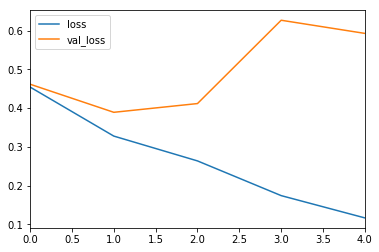

In [12]:
import matplotlib.pyplot as plt
metrics[['loss' , 'val_loss']].plot()
plt.show()

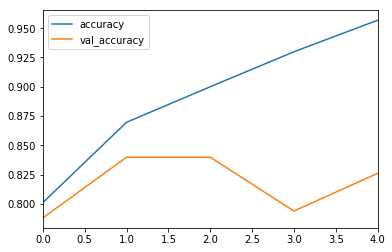

In [13]:
metrics[['accuracy' , 'val_accuracy']].plot()
plt.show()

In [14]:
model.load_weights('model.h5')
test_pred = model.predict(test_input)

In [15]:
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)